In [6]:
import sys
import os
import datetime

base_folder = r'D:\measuring'

if not base_folder in sys.path:
    sys.path.append(base_folder)
execfile(os.path.join(base_folder,r'analysis\scripts\setup_analysis.py'))
execfile(os.path.join(base_folder,r'analysis\scripts\bell\setup_bell_analysis.py'))
%matplotlib inline


d:\measuring\data
reloaded
d:\measuring\data


In [95]:
measurement_pattern = 'ZPL_SPCORR_lt4'
#bs_folder=r'X:\data\20150626\165758_Bell_BS_SPCORR_ZPL_SPCORR_lt4'
bs_folder = tb.latest_data(measurement_pattern, folder = r'X:\data')
lt4_folder = r'D:\measuring\data'
fbs_folder = tb.get_all_msmt_filepaths(bs_folder, pattern=measurement_pattern)
output_folder = tb.latest_data(measurement_pattern, folder = lt4_folder)
analysis_fp = os.path.join(output_folder,tb.get_timestamp_from_now()+'_'+'total_events.hdf5')


In [96]:
bell_data.process_bell_data(fbs_folder, None, lt4_folder,# measurement_pattern, 
                            settings.bs_process_params, settings.lt_process_params,
                            analysis_fp, update_previous_analysis_fp = None, 
                            ignore_unequal_markers   = False, 
                            process_lt3 = False, process_lt4 = True, 
                            VERBOSE=True)
#here we get a list of files that actually contributed to the data ie had at leas one entanglement event
bs_fps, lt3_fps, lt4_fps = bell_data.get_unique_bell_fps_from_analysis_file(analysis_fp)
print ''


Found 1 filepaths
0 Found 1549 entanglement markers in X:\data\20151231\083315_Bell_BS_SPCORR_ZPL_SPCORR_lt4\083315_Bell_BS_SPCORR_ZPL_SPCORR_lt4.hdf5
Of which 0 are valid entanglement events
and of which 1549 are valid spin-photon events
Found 1549 entanglement markers in D:\measuring\data\20151231\083334_Bell_lt4_SPCORR_ZPL_SPCORR_lt4\083334_Bell_lt4_SPCORR_ZPL_SPCORR_lt4.hdf5-2
Measurement with filepath X:\data\20151231\083315_Bell_BS_SPCORR_ZPL_SPCORR_lt4\083315_Bell_BS_SPCORR_ZPL_SPCORR_lt4.hdf5 has more than 100 events
Done, total_events: 1549



In [97]:
#analyse data correlations
f = h5py.File(analysis_fp,'r')
db = f['analysis']['total_ent_events'].value
d3 = f['analysis']['total_lt3_ssro'].value
d4 = f['analysis']['total_lt4_ssro'].value
db_fps=f['analysis']['total_ent_events_fps'].value
f.close()
reload(settings)
set2=settings.analysis_params

#set2['st_start_ch0']=5426000
#set2['st_start_ch1']=5426000#50+1000
#set2['st_len']=5000
corr_mats = btools.get_sp_corrs(db,d4,db_fps, set2, lt3=False)


I changed stuff in get_sp_corrs!!! Norbert


5425.3
The number of markers is: 1549


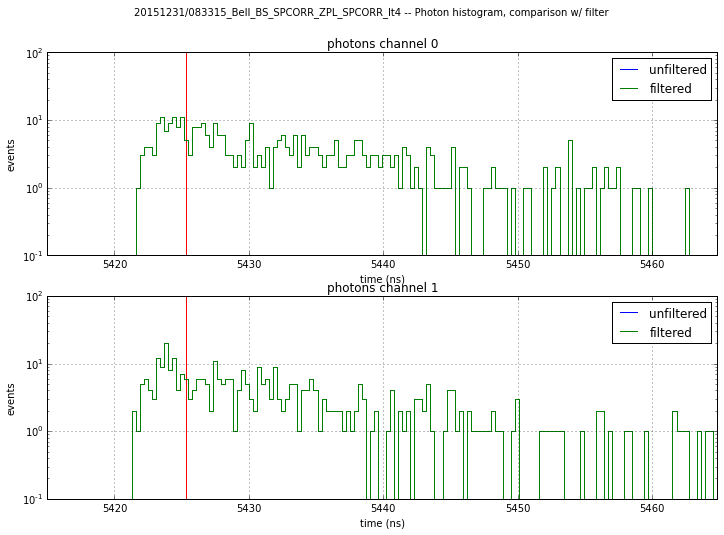

In [98]:
fp  = tb.get_msmt_fp(bs_folder) #bs_fps[0]
pqf = h5py.File(fp,'r')
vert0 = settings.analysis_params['st_start_ch0']/1000.
print vert0
vert1 = settings.analysis_params['st_start_ch1']/1000.
pq_plots.plot_marker_filter_comparison(pqf,
                          mrkr_chan = 1,
                          start = 5415000, #settings.bs_process_params['st_start_ch0'],  
                          length=  50e3,#settings.bs_process_params['st_len']+settings.bs_process_params['pulse_sep'], 
                          hist_binsize = 0.3e3, save = False, log=True, plot_threshold_ch0 =vert0 ,plot_threshold_ch1 =vert1) #start =7480

pqf.close()

In [99]:
#here we get the tail & pulse counts per run
bell_data.process_bs_hist_stats(bs_fps, settings.analysis_params ,analysis_fp, update_previous_analysis_fp = None)
print ''


Processing tail 1 files
0 Done!



In [100]:
f = h5py.File(analysis_fp,'r')
bs_hist_stats = f['analysis']['bs_hist_stats'].value
f.close()
tail  = np.sum(bs_hist_stats[:,be._cl_bs_tail].astype(np.float))/np.sum(bs_hist_stats[:,be._cl_bs_last_sync])*1e4
u_tail = np.sqrt(np.sum(bs_hist_stats[:,be._cl_bs_tail].astype(np.float)))/np.sum(bs_hist_stats[:,be._cl_bs_last_sync])*1e4
print 'Tail: {:.2f} +- {:.3f}'.format(tail,u_tail)
print' compare to 1.4'

Tail: 1.47 +- 0.044
 compare to 1.4


ZPL SP corr from date : 20151231/083334
	Tail counts : 1.47 +- 0.044
	Uncorrected readout : W1 : 1.8 +/- 0.6 % & W2 : 92.4 +/- 1.1 %
	Corrected readout : W1 : 1.4 +/- 1.3 % & W2 : 98.5 +/- 1.3 %
thresholds are met


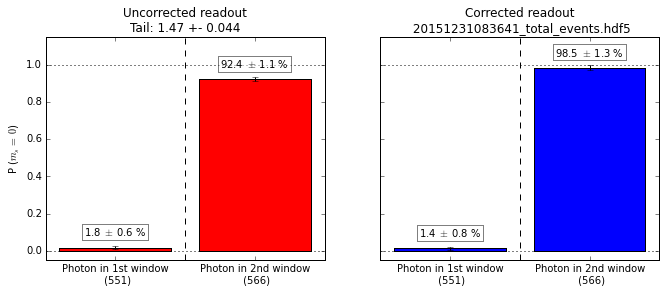

In [101]:
# P_ms1 generally stands for the probability to measure ms=1
# P_photon is the probability for getting a photon
win1_P_photon, u_win1_P_photon = corr_mats['w1'][0:2]
noof_w1 = corr_mats['w1'][4]
win2_P_photon, u_win2_P_photon = corr_mats['w2'][0:2]
noof_w2 = corr_mats['w2'][4]

fig, (ax, ax_corr) = plt.subplots(1,2, figsize=(11,4),
                              sharex=True, sharey=True)

### uncorrected for e-SSRO
ax.bar(range(2), [win1_P_photon, win2_P_photon], color=['r', 'r'],
       align='center', yerr=[u_win1_P_photon, u_win2_P_photon], ecolor='k',
       width=0.8)

ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.05, 1.15)

ax.set_ylabel('P ($m_s =\, 0$)')

ax.set_xticks([0,1])
ax.set_xticklabels(['Photon in 1st window \n ({})'.format(noof_w1),
                    'Photon in 2nd window \n ({})'.format(noof_w2)])
ax.axvline(0.5, c='k', ls='--')
ax.axhline(0, c='k', ls=':')
ax.axhline(1, c='k', ls=':')

ax.text(0, win1_P_photon + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win1_P_photon*100, u_win1_P_photon*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax.text(1, win2_P_photon + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win2_P_photon*100, u_win2_P_photon*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax.set_title('Uncorrected readout\nTail: {:.2f} +- {:.3f}'.format(tail,u_tail))

### corrected for e-SSRO
win1_P0, u_win1_P0 = corr_mats['w1'][2:4]
win2_P0, u_win2_P0 = corr_mats['w2'][2:4]

ax_corr.bar(range(2), [win1_P0, win2_P0], color=['b','b'],
       align='center', yerr=[u_win1_P0, u_win2_P0], ecolor='k',
       width=0.8)
ax_corr.axvline(0.5, c='k', ls='--')
ax_corr.axhline(0, c='k', ls=':')
ax_corr.axhline(1, c='k', ls=':')

ax_corr.text(0, win1_P0 + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win1_P0*100, u_win1_P0*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax_corr.text(1, win2_P0 + 0.05, "{:.1f} $\pm$ {:.1f} %".format(win2_P0*100, u_win2_P0*100),
        va='bottom', ha='center',
        bbox = {'facecolor' : 'white', 'alpha' : 0.5})
ax_corr.set_title('Corrected readout \n '+os.path.split(analysis_fp)[1])
fig.savefig(os.path.join(output_folder, 'Spin-photon_correlations.png'))

print 'ZPL SP corr from date : {}'.format(tb.get_plot_title_from_folder(output_folder)[:15])
print '\tTail counts : {:.2f} +- {:.3f}'.format(tail,u_tail)
print '\tUncorrected readout : W1 : {:.1f} +/- {:.1f} % & W2 : {:.1f} +/- {:.1f} %'.format(win1_P_photon*100, u_win1_P_photon*100,win2_P_photon*100, u_win2_P_photon*100)
print '\tCorrected readout : W1 : {:.1f} +/- {:.1f} % & W2 : {:.1f} +/- {:.1f} %'.format(win1_P0*100, u_win2_P0*100,win2_P0*100, u_win2_P0*100)
if win2_P_photon>0.915 and win1_P_photon<0.02 and tail > 1.4:
    print 'thresholds are met'
else:
    print 'thresholds are NOT met: compare to 91.5 and 2, and 1.4 tail'
